In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter

## References:

- [A Fast Approximation of the Bilateral Filter
using a Signal Processing Approach](https://people.csail.mit.edu/sparis/publi/2006/eccv/Paris_06_Fast_Approximation.pdf)


## Bilateral Grid 1D simulation

In [2]:
DYNAMIC_RANGE = 2**12 - 1
OUTPUT_RANGE = 255


def generate_1d_signal(gain=500):
    x = np.linspace(0, 128, 128)
    yy = (0.7 - 0.28) / (30 - 90) * (x-30) + 0.7
    
    y = np.where((30 < x) & (x <= 90), yy, 0.28)
    y[x > 90] = 0.7
    
    sig = np.random.poisson(y * gain)
    sig = sig / gain
    sig = np.clip(sig, 0.0, 1.0)
    return sig * DYNAMIC_RANGE

def construct_2d_grid(sig, n_sample=32):
    # normalize to (0, 1]
    sig_normalized = sig /DYNAMIC_RANGE
    n = len(sig)
    
    bins = np.linspace(0, 1, n_sample-1)
    r = np.digitize(sig_normalized, bins)
    s = np.arange(0, n)
    
    w = np.zeros(shape=(n_sample, n))
    w[r, s] = 1
    wi = w * sig[None, :]
    return np.flip(w, axis=0), np.flip(wi, axis=0)

def gaussian_filter_2d_grid(w, wi, sigma_r, sigma_s):
    w_bf  = gaussian_filter(w, sigma=[sigma_r, sigma_s])
    wi_bf = gaussian_filter(wi, sigma=[sigma_r, sigma_s])
    
    return w_bf, wi_bf

def slicing(sig, w_bf, wi_bf):
    sig_normalized = sig /DYNAMIC_RANGE
    w_bf_flip = np.flip(w_bf, axis=0)
    wi_bf_flip = np.flip(wi_bf, axis=0)

    n_samples, n_pix = w_bf.shape
    bins = np.linspace(0, 1, n_samples-1)
    r = np.digitize(sig_normalized, bins)
    s = np.arange(0, n_pix)
        
    w_s = w_bf_flip[r, s]
    wi_s = wi_bf_flip[r, s]
    return r, s, w_s, wi_s

In [3]:
def bilateral_grid_1d(sig, sigma_r, sigma_s):
    w, wi = construct_2d_grid(sig)
    w_bf, wi_bf = gaussian_filter_2d_grid(w, wi, sigma_r=3, sigma_s=5)
    r, s, w_s, wi_s = slicing(sig, w_bf, wi_bf)
    sig_bf = wi_s / w_s
    return sig_bf

In [4]:
sigma_r=6
sigma_s=5
sig = generate_1d_signal(gain=200)
w, wi = construct_2d_grid(sig)
w_bf, wi_bf = gaussian_filter_2d_grid(w, wi, sigma_r=sigma_r, sigma_s=sigma_s)
r, s, w_s, wi_s = slicing(sig, w_bf, wi_bf)
sig_bf = wi_s / w_s

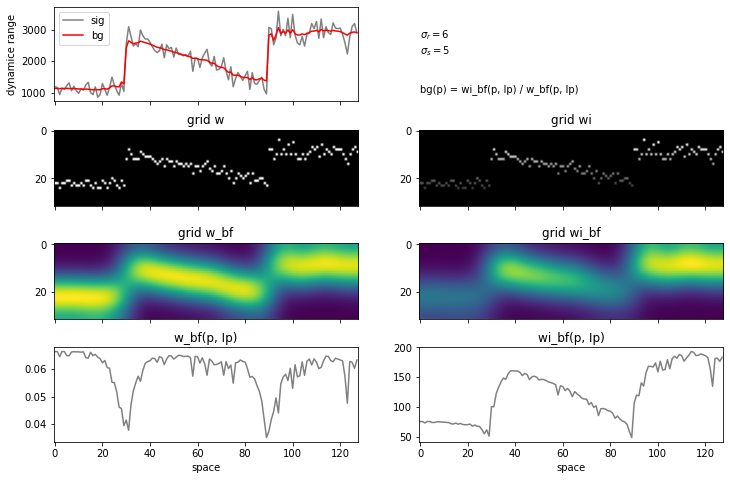

In [5]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex='col', figsize=(12, 8))

axes[0, 1].axis(False)
axes[0, 1].text(0, 0.5, f"$\sigma_r = {sigma_r}$ \n$\sigma_s={sigma_s}$")
axes[0, 1].text(0, 0.1, "bg(p) = wi_bf(p, Ip) / w_bf(p, Ip)")


axes[0, 0].plot(np.arange(128), sig, color='gray', label="sig")
axes[0, 0].plot(np.arange(128), sig_bf, color='red', label="bg")
axes[0, 0].set_ylabel("dynamice range")
axes[0, 0].legend()

axes[1, 0].imshow(w, cmap='gray')
axes[1, 1].imshow(wi, cmap='gray')
axes[1, 0].set_title("grid w")
axes[1, 1].set_title("grid wi")

axes[2, 0].imshow(w_bf)
axes[2, 1].imshow(wi_bf)
axes[2, 0].set_title("grid w_bf")
axes[2, 1].set_title("grid wi_bf")

w_bf_flip  = np.flip(w_bf,  axis=0).copy()
wi_bf_flip = np.flip(wi_bf, axis=0).copy()

w_bf_flip[r, s] = w_bf_flip.max() * 1.3
wi_bf_flip[r, s] = wi_bf_flip.max() * 1.3
w_s_bf  = np.flip(w_bf_flip,  axis=0)
wi_s_bf = np.flip(wi_bf_flip, axis=0)
axes[3, 0].plot(w_s, color='gray')
axes[3, 1].plot(wi_s, color='gray')
axes[3, 0].set_title("w_bf(p, Ip)")
axes[3, 1].set_title("wi_bf(p, Ip)")

axes[3, 0].set_xlabel("space")
axes[3, 1].set_xlabel("space")

fig.subplots_adjust(wspace=0.2, hspace=0.2)

## Simulate Halo Effect

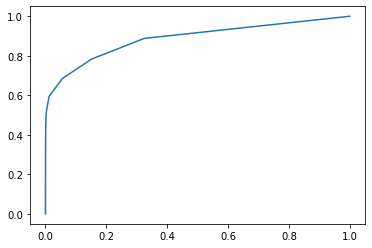

In [6]:
ltm_curve = np.array([
    [0.000000, 0.000000],
    [0.000028, 0.001537],
    [0.000040, 0.007063],
    [0.000060, 0.017235],
    [0.000080, 0.032454],
    [0.000110, 0.053024],
    [0.000139, 0.079191],
    [0.000182, 0.111162],
    [0.000223, 0.149121],
    [0.000281, 0.193230],
    [0.000334, 0.243636],
    [0.000410, 0.300473],
    [0.000574, 0.363865],
    [0.000962, 0.433928],
    [0.002350, 0.510768],
    [0.011968, 0.594488],
    [0.055835, 0.685182],
    [0.151204, 0.782942],
    [0.324518, 0.887854],
    [1.000000, 1.000000],
])

plt.plot(ltm_curve[:,0], ltm_curve[:, 1])

In [7]:
def construct_1d_img():
    np.random.seed(0)
    x = np.linspace(0, 128, 128)    
    y = np.zeros_like(x)
    
    y =  (np.exp(-(x-50)**2/60) + 0.1)
#     y += 0.1
#     y /= y.max()
    y = np.clip(y, 0, 1)

    y *= DYNAMIC_RANGE
    sig = np.random.poisson(y)
    sig = np.clip(sig, 0.0, DYNAMIC_RANGE)
    return sig .astype(np.uint32)

def simple_tone_map(img, input_range, output_range=255):
    curve = ltm_curve.copy()
    s = img / input_range
    
    s_interp = np.interp(s, curve[:, 0], curve[:, 1])
    return s_interp * output_range
    

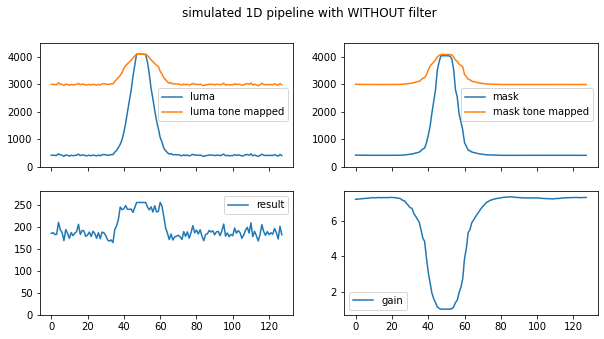

In [8]:

luma = construct_1d_img()
mask = bilateral_grid_1d(luma, sigma_r=9, sigma_s=5)
# mask = gaussian_filter(mask, sigma=8)

luma_tm = simple_tone_map(luma, input_range=DYNAMIC_RANGE, output_range=DYNAMIC_RANGE)
mask_tm = simple_tone_map(mask, input_range=DYNAMIC_RANGE, output_range=DYNAMIC_RANGE)


detail_gain = (luma_tm / mask_tm - 1.0) * 0.1 + 1.0
mask_gain = mask_tm / mask
gain = mask_gain * detail_gain

luma_result = luma * gain
luma_result = OUTPUT_RANGE * (luma_result / DYNAMIC_RANGE)
luma_result = np.clip(luma_result, 0, OUTPUT_RANGE)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex='all', figsize=(10, 5))

ax1.plot(luma,   label="luma")
ax1.plot(luma_tm, label="luma tone mapped")

ax2.plot(mask,   label = "mask")
ax2.plot(mask_tm, label = "mask tone mapped")

ax3.plot(luma_result, label = "result")
ax4.plot(gain, label="gain")

for ax in (ax1, ax2, ax3, ax4):
    ax.legend()
    
for ax in (ax1, ax2):
    ax.set_ylim([0, DYNAMIC_RANGE * 1.1])
ax3.set_ylim([0, OUTPUT_RANGE*1.1])


plt.suptitle("simulated 1D pipeline with WITHOUT filter");

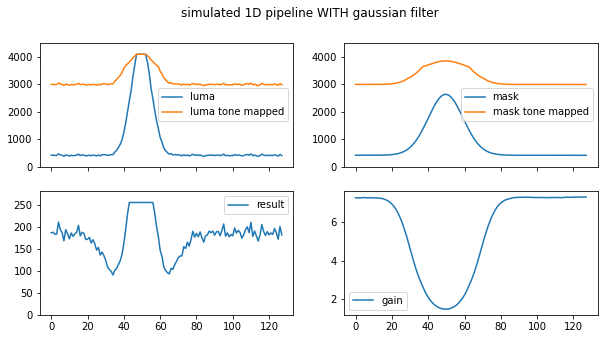

In [9]:
luma = construct_1d_img()
mask = bilateral_grid_1d(luma, sigma_r=9, sigma_s=5)
mask = gaussian_filter(mask, sigma=8)

luma_tm = simple_tone_map(luma, input_range=DYNAMIC_RANGE, output_range=DYNAMIC_RANGE)
mask_tm = simple_tone_map(mask, input_range=DYNAMIC_RANGE, output_range=DYNAMIC_RANGE)


detail_gain = (luma_tm / mask_tm - 1.0) * 0.1 + 1.0
mask_gain = mask_tm / mask
gain = mask_gain * detail_gain

luma_result = luma * gain
luma_result = OUTPUT_RANGE * (luma_result / DYNAMIC_RANGE)
luma_result = np.clip(luma_result, 0, OUTPUT_RANGE)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex='all', figsize=(10, 5))

ax1.plot(luma,   label="luma")
ax1.plot(luma_tm, label="luma tone mapped")

ax2.plot(mask,   label = "mask")
ax2.plot(mask_tm, label = "mask tone mapped")

ax3.plot(luma_result, label = "result")
ax4.plot(gain, label="gain")

for ax in (ax1, ax2, ax3, ax4):
    ax.legend()
    
for ax in (ax1, ax2):
    ax.set_ylim([0, DYNAMIC_RANGE * 1.1])
ax3.set_ylim([0, OUTPUT_RANGE*1.1])


plt.suptitle("simulated 1D pipeline WITH gaussian filter");

## 结论：

Bilateral Grid 加 Gaussian Filter 会导致 Halo.